# Kimberlite TFA Inversion

This notebook performs the inversion using Levenberg-Marquadt's algorithm of total field anomaly (TFA) data on a regular grid of a synthetic kimberlitic model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
from fatiando import utils
from fatiando.gravmag import polyprism
from fatiando.vis import mpl

/home/leo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


### Auxiliary functions

In [2]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

In [3]:
from datetime import datetime
today = datetime.today()
# dd/mm/YY/Hh/Mm
d4 = today.strftime("%d-%b-%Y-%Hh:%Mm")

# Input

In [4]:
model_dir = 'model.pickle'
grid_dir = 'grid.pickle'
data_dir = 'data.pickle'

### Importing model parameters

In [5]:
with open(model_dir) as w:
        model = pickle.load(w)

### Observation points and observed data

In [6]:
with open(grid_dir) as w:
        grid = pickle.load(w)

In [7]:
with open(data_dir) as w:
        data = pickle.load(w)

In [8]:
# observed data and observation points
dobs = data['tfa_obs']
xp = grid['x']
yp = grid['y']
zp = grid['z']
N = grid['N']

### Parameters of the initial model

In [9]:
M = 20 # number of vertices per prism
L = 5 # number of prisms
P = L*(M+2) + 1 # number of parameters

# magnetization direction
incs = model['inc']
decs = model['dec']

# depth to the top, thickness and radius
z0 = model['z0']
dz = 450.
r = 2000.

# total magnetization
intensity = model['intensity']
props = {'magnetization': utils.ang2vec(
        intensity, incs, decs)}
rin = np.zeros(M) + r
m0 = np.hstack((rin, np.zeros(2)))
m0 = np.resize(m0, P - 1) 
m0 = np.hstack((m0, dz)) # inicial parameters vector
model0 = mfun.param2polyprism(m0, M, L, z0, props) # list of classes of prisms

# main field
inc, dec = data['main_field']

# predict data
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec)

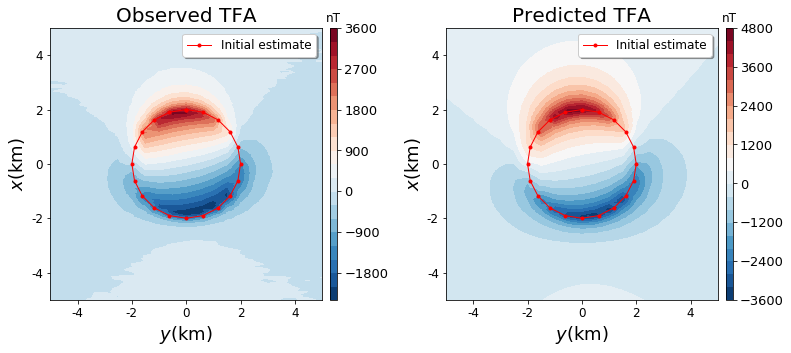

In [10]:
plt.figure(figsize=(13,5))

plt.subplot(121)
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)

plt.subplot(122)
plt.title('Predicted TFA', fontsize=20)
plt.tricontourf(yp, xp, d0, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)

plt.show()

### Limits

In [11]:
# limits for parameters in meters
rmin = 10.
rmax = 3000.
x0min = -4000.
x0max = 4000.
y0min = -4000.
y0max = 4000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [12]:
# variation for derivatives
deltax = 0.01*np.max(1000)
deltay = 0.01*np.max(1000)
deltar = 0.01*np.max(1000)
deltaz = 0.01*np.max(1000)

delta = np.array([deltax, deltay, deltar, deltaz])

### Outcropping parameters

In [13]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

### Regularization parameters

In [14]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-3  # adjacent radial distances within each prism
a2 = 1.0e-4   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-4     # vertically adjacent origins
a6 = 1.0e-6   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-5     # zero order Tikhonov on thickness of each prism

alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

### Folder to save the results

In [15]:
foldername = ''

In [16]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

### Inversion

In [17]:
d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.levmarq_tf(
    xp, yp, zp, m0, M, L, delta,
    itmax, itmax_marq, lamb,
    dlamb, tol, mmin, mmax,
    m_out, dobs, inc, dec,
    props, alpha, z0, dz
)

it:  0   it_marq:  0   lambda: 1e+01   init obj.: 1.57883e+05  fin obj.: 6.49973e+04
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 6.49973e+04  fin obj.: 1.27185e+04
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 1.27185e+04  fin obj.: 2.11468e+03
it:  3   it_marq:  0   lambda: 1e-02   init obj.: 2.11468e+03  fin obj.: 6.38151e+03
it:  3   it_marq:  1   lambda: 1e-01   init obj.: 2.11468e+03  fin obj.: 2.90347e+03
it:  3   it_marq:  2   lambda: 1e+00   init obj.: 2.11468e+03  fin obj.: 8.49749e+02
it:  4   it_marq:  0   lambda: 1e-01   init obj.: 8.49749e+02  fin obj.: 3.03488e+03
it:  4   it_marq:  1   lambda: 1e+00   init obj.: 8.49749e+02  fin obj.: 6.35977e+02
it:  5   it_marq:  0   lambda: 1e-01   init obj.: 6.35977e+02  fin obj.: 2.33117e+03
it:  5   it_marq:  1   lambda: 1e+00   init obj.: 6.35977e+02  fin obj.: 5.01595e+02
it:  6   it_marq:  0   lambda: 1e-01   init obj.: 5.01595e+02  fin obj.: 1.91963e+03
it:  6   it_marq:  1   lambda: 1e+00   init obj.: 5.01595e+02  fi

# Results

In [18]:
# output of inversion
inversion = dict()

inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp
inversion['observed_data'] = dobs
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['initial_estimate'] = model0
inversion['initial_data'] = d0
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = np.array([a1, a2, a3, a4, a5, a6, a7])
inversion['tol'] = tol
inversion['main_field'] = [data['main_field'][0], data['main_field'][1]]
inversion['data_fit'] = d_fit
inversion['estimate'] = m_est
inversion['prisms'] = model_est
inversion['estimated_models'] = model_list
inversion['objective'] = phi_list
inversion['residual'] = dobs - d_fit
inversion['residual_list'] = res_list

In [19]:
if foldername == '':
    mypath = 'results/single-'+d4 #default folder name
    if not os.path.isdir(mypath):
       os.makedirs(mypath)
else:
    mypath = 'results/single-'+foldername #defined folder name
    if not os.path.isdir(mypath):
       os.makedirs(mypath)

In [20]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)